# Librerias 


In [ ]:
# Instalamos keras-tuner
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import scipy.stats as ss
import numpy as np
import plotly.express as px
import pickle
import time
import json
import os

from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer, confusion_matrix,classification_report, f1_score

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
import keras_tuner as kt
# import visualkeras

np.random.seed(1)
tf.random.set_seed(1) 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
path_submissions = 'submissions/'

os.makedirs(path_submissions, exist_ok=True)

In [ ]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.12.0
[]


# Importación del dataset

In [ ]:
url_train_encoded = 'https://raw.githubusercontent.com/FrancoSecchi/7506R-1C2023-GRUPO02/checkpoint-4/checkpoint-4/df_hotels_train_encoded.csv'
url_test_encoded = 'https://raw.githubusercontent.com/FrancoSecchi/7506R-1C2023-GRUPO02/checkpoint-4/checkpoint-4/df_hotels_test_encoded.csv'
url_train = 'https://raw.githubusercontent.com/FrancoSecchi/7506R-1C2023-GRUPO02/checkpoint-4/checkpoint-4/hotels-train.csv'
url_test = 'https://raw.githubusercontent.com/FrancoSecchi/7506R-1C2023-GRUPO02/checkpoint-4/checkpoint-4/hotels-test.csv'
df_train_encoded = pd.read_csv(url_train_encoded)
df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)
df_test_encoded = pd.read_csv(url_test_encoded)

In [ ]:
df_hotels_train_encoded = df_train_encoded.copy()
df_hotels_test_encoded = df_test_encoded.copy()
df_hotels_train = df_train.copy()
df_hotels_test = df_test.copy()

In [ ]:
df_hotels_train_encoded.drop(columns=["Unnamed: 0"], inplace=True)
df_hotels_train.drop(columns=["Unnamed: 0"], inplace=True)
df_hotels_test.drop(columns=["Unnamed: 0"], inplace=True)

In [ ]:
df_hotels_train_encoded.columns

Index(['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'id', 'is_canceled', 'hotel_Resort Hotel',
       'market_segment_Complementary', 'market_segment_Corporate',
       'market_segment_Direct', 'market_segment_Groups',
       'market_segment_Offline TA/TO', 'market_segment_Online TA',
       'distribution_channel_Direct', 'distribution_channel_GDS',
       'distribution_channel_TA/TO', 'reserved_room_type_B',
       'reserved_room_type_C', 'reserved_room_type_D', 'reserved_room_type_E',
       'reserved_room_type_F', 'reserved_room_type_G', 'reserved_room_type_H',
       'reserved_room_type_L', 'reserved_room_type_P',
       'deposit_type_Non Refund', 'deposit_type_Refundable',
       'customer_type_Group',

# Funciones auxiliares

In [ ]:
RMSPROP_NAME = "RMSprop"
SGD_NAME = "SGD"
ADADELTA_NAME = "ADADELTA"
ADAM_NAME = "ADAM"
NN_OPT_NAME= "OPT_NN"

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [ ]:
def show_performance(y_test, y_pred):
  print(f"F1 Score: {f1_score(y_test, y_pred, average='binary')}")
  print(f"Classification Report: \n {classification_report(y_test, y_pred)}")
  matrix = confusion_matrix(y_test, y_pred)
  sns.heatmap(matrix, cmap='Greens', annot=True, fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')

In [ ]:

def create_model_submission(df_hotels_test, model, optimizerName , score):
  # Nos traemos el dataset de test sin el ID.
  x_sub = df_hotels_test.select_dtypes(exclude=['object'])

  # Predecimos con nuestro mejor modelo
  y_sub = model.predict(x_sub)
  y_sub = np.argmax(y_sub,axis=1).tolist()


  # Armamos un DF
  df_sub = pd.DataFrame({'id': df_hotels_test['id'], 'is_canceled': y_sub})

  timestr = time.strftime("%Y%m%d-%H%M%S")
  path = f'submissions/{optimizerName}_{timestr}/'
  os.mkdir(path)

  df_sub.to_csv(path + f'{score}.csv', index=False)

  # Persistimos el modelo asociado.
  model_filename = path + 'modelo.pickle'
  pickle.dump(model, open(model_filename, "wb"))



#Normalización de datos

In [ ]:
df_hotels_train.columns

Index(['hotel', 'lead_time', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'deposit_type', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests', 'id',
       'is_canceled'],
      dtype='object')

In [ ]:
df_hotels_train.describe()

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,adr,required_car_parking_spaces,total_of_special_requests,is_canceled
count,59477.000000,59477.000000,59477.000000,59477.000000,59477.000000,59477.000000,59477.000000,59477.000000,59477.000000,59477.000000,59477.000000,59477.000000,59477.000000,59477.000000,59477.000000
mean,105.922390,27.062596,15.788742,0.927552,2.508583,1.862703,0.087715,0.006843,0.028414,0.088253,0.119542,101.556938,0.049633,0.526086,0.493216
std,99.842686,13.592855,8.791202,0.994206,1.894073,0.584636,0.360171,0.083654,0.166155,0.530491,1.423823,41.317449,0.220338,0.774609,0.499958
min,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,22.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,72.000000,0.000000,0.000000,0.000000
50%,75.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000,0.000000
75%,166.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,125.670000,0.000000,1.000000,1.000000
max,414.000000,53.000000,31.000000,16.000000,40.000000,55.000000,2.000000,2.000000,1.000000,19.000000,70.000000,235.070000,8.000000,5.000000,1.000000


In [ ]:
cols_numericas = [columna for columna in df_hotels_train.columns if np.issubdtype(df_hotels_train[columna].dtype, np.number)]
cols_numericas.remove('is_canceled')
cols_numericas.remove('is_repeated_guest')
cols_numericas

['lead_time',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [ ]:
# Creamos el scaler
scaler = StandardScaler()

# Alimentamos el scaler con los datos de TRAIN.
scaler.fit(pd.DataFrame(df_hotels_train[cols_numericas]))

# Aplicamos las transformaciones a el dataset de Train y al de TEST para nuestra prediccion de Kaggle.
df_hotels_train[cols_numericas]=scaler.transform(df_hotels_train[cols_numericas])
df_hotels_test[cols_numericas]=scaler.transform(df_hotels_test[cols_numericas])

In [ ]:
# Evaluar si el reservation_year es necesario hacerle dummies.
dummy_columns = ["hotel","market_segment","distribution_channel", "reserved_room_type", "deposit_type", "customer_type", "meal"]

#Train
df_hotels_train = pd.get_dummies(df_hotels_train, columns=dummy_columns, drop_first=True)
#Test
df_hotels_test = pd.get_dummies(df_hotels_test, columns=dummy_columns, drop_first=True)

In [ ]:
loc_room_type_L = df_hotels_train.columns.get_loc('reserved_room_type_L')
df_hotels_train.insert(loc=loc_room_type_L+1, column='reserved_room_type_P', value=0)

# Separación de conjuntos de Test y Train

In [ ]:
x_model = df_hotels_train
y_model = df_hotels_train['is_canceled']
x_model.drop('id', axis=1, inplace=True)
x_model.drop('is_canceled', axis=1, inplace=True)


#Podemos ver que el numero de filas coincide.
assert(x_model.shape[0] == y_model.shape[0])
print(f"Shape del X: {x_model.shape} y Shape del Y: {y_model.shape}")

Shape del X: (59477, 41) y Shape del Y: (59477,)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_model, 
                                                    y_model,
                                                    test_size=0.2,
                                                    random_state=199,
                                                    )

len(x_train) , len(x_test)

(47581, 11896)

In [ ]:
enc = OneHotEncoder()
y_train_encoder = enc.fit_transform(np.array(y_train)[:, np.newaxis]).toarray()
y_test_encoder = enc.transform(np.array(y_test)[:, np.newaxis]).toarray()

<ipython-input-21-6b45571d5ffb>:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_train_encoder = enc.fit_transform(y_train[:, np.newaxis]).toarray()
<ipython-input-21-6b45571d5ffb>:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_test_encoder = enc.transform(y_test[:, np.newaxis]).toarray()


En la clase de redes, le hacen un scaler a train y test, no estoy seguro si hay que hacerlo, tengo mis dudas

# Red neuronal


In [ ]:
# calcula la cantidad de clases
cant_clases=len(np.unique(y_model))

d_in=len(x_model.columns.to_list())

algunos optimizadores como Adam y Adagrad pueden ser más eficientes en términos de memoria y tiempo de cómputo en comparación con otros optimizadores como SGD, especialmente cuando se trabaja con grandes conjuntos de datos. Además, el tamaño del lote (batch size) también puede afectar el rendimiento del optimizador en conjuntos de datos grandes.

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(100, input_shape=(d_in,), activation='sigmoid', kernel_initializer='uniform'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(50))
model.add(keras.layers.Dense(units=100, activation='tanh', kernel_regularizer='l2', bias_initializer='zeros'))
model.add(keras.layers.Dense(cant_clases, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4200      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 100)               5100      
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
Total params: 14,552
Trainable params: 14,552
Non-trainable params: 0
_________________________________________________________________


# Optimizadores

### SGD

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=[f1_m])

In [ ]:
historial_model = model.fit(x_train, y_train_encoder, epochs=100, batch_size=32)

Epoch 1/100
1487/1487 [==============================] - 5s 3ms/step - loss: 1.1956 - f1_m: 0.5732
Epoch 2/100
1487/1487 [==============================] - 3s 2ms/step - loss: 0.9097 - f1_m: 0.6509
Epoch 3/100
1487/1487 [==============================] - 9s 6ms/step - loss: 0.7429 - f1_m: 0.6835
Epoch 4/100
1487/1487 [==============================] - 6s 4ms/step - loss: 0.6543 - f1_m: 0.6996
Epoch 5/100
1487/1487 [==============================] - 3s 2ms/step - loss: 0.6021 - f1_m: 0.7090
Epoch 6/100
1487/1487 [==============================] - 5s 4ms/step - loss: 0.5722 - f1_m: 0.7143
Epoch 7/100
1487/1487 [==============================] - 6s 4ms/step - loss: 0.5534 - f1_m: 0.7207
Epoch 8/100
1487/1487 [==============================] - 4s 2ms/step - loss: 0.5393 - f1_m: 0.7251
Epoch 9/100
1487/1487 [==============================] - 4s 3ms/step - loss: 0.5333 - f1_m: 0.7275
Epoch 10/100
1487/1487 [==============================] - 5s 4ms/step - loss: 0.5264 - f1_m: 0.7316
Epoch 11/

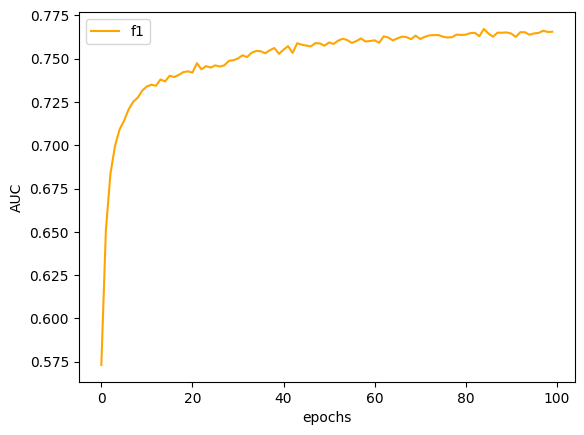

In [ ]:
epochs = range(100)

plt.plot(epochs, historial_model.history['f1_m'], color='orange', label='f1')
plt.xlabel("epochs")
plt.ylabel("AUC")
plt.legend()

In [ ]:
y_predic = model.predict(x_test)

372/372 [==============================] - 1s 1ms/step


In [ ]:
max(historial_model.history['f1_m'])

0.7671564817428589

In [ ]:
y_predic_classes = np.argmax(y_predic,axis=1).tolist()
y_real = np.argmax(y_test_encoder,axis=1).tolist()

F1 Score: 0.7504366210129608
Classification Report: 
               precision    recall  f1-score   support

           0       0.73      0.86      0.79      5959
           1       0.83      0.69      0.75      5937

    accuracy                           0.77     11896
   macro avg       0.78      0.77      0.77     11896
weighted avg       0.78      0.77      0.77     11896



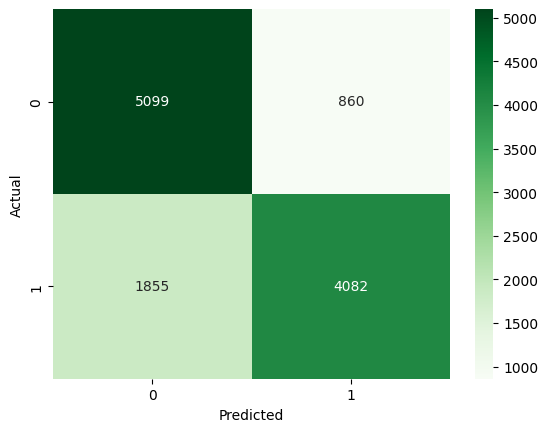

In [ ]:
show_performance(y_real, y_predic_classes)

#### Kaggle

In [ ]:
create_model_submission(df_hotels_test, model, SGD_NAME, f1_score(y_real, y_predic_classes, average='binary'))

830/830 [==============================] - 1s 1ms/step


### Adam

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate = 0.01, beta_1=0.9, beta_2= 0.99)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f1_m])

In [ ]:
historial_model = model.fit(x_train, y_train_encoder, epochs=100, batch_size=32)

Epoch 1/100
1487/1487 [==============================] - 8s 5ms/step - loss: 0.4807 - f1_m: 0.7625
Epoch 2/100
1487/1487 [==============================] - 6s 4ms/step - loss: 0.4616 - f1_m: 0.7725
Epoch 3/100
1487/1487 [==============================] - 6s 4ms/step - loss: 0.4507 - f1_m: 0.7772
Epoch 4/100
1487/1487 [==============================] - 5s 3ms/step - loss: 0.4449 - f1_m: 0.7835
Epoch 5/100
1487/1487 [==============================] - 5s 3ms/step - loss: 0.4399 - f1_m: 0.7871
Epoch 6/100
1487/1487 [==============================] - 8s 5ms/step - loss: 0.4392 - f1_m: 0.7883
Epoch 7/100
1487/1487 [==============================] - 5s 3ms/step - loss: 0.4344 - f1_m: 0.7919
Epoch 8/100
1487/1487 [==============================] - 6s 4ms/step - loss: 0.4317 - f1_m: 0.7936
Epoch 9/100
1487/1487 [==============================] - 5s 3ms/step - loss: 0.4301 - f1_m: 0.7945
Epoch 10/100
1487/1487 [==============================] - 3s 2ms/step - loss: 0.4305 - f1_m: 0.7960
Epoch 11/

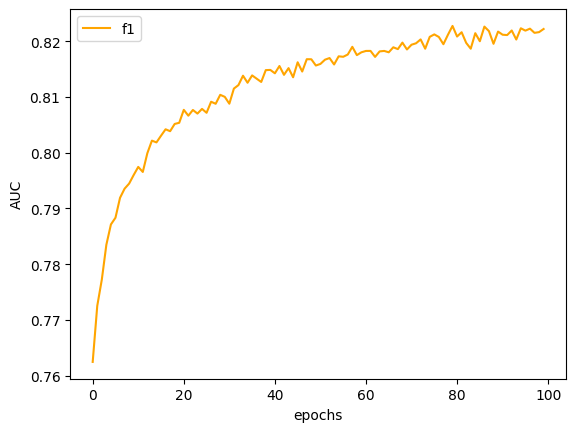

In [ ]:
epochs = range(100)

plt.plot(epochs, historial_model.history['f1_m'], color='orange', label='f1')
plt.xlabel("epochs")
plt.ylabel("AUC")
plt.legend()

In [ ]:
epochs = range(100)

plt.plot(epochs, historial_model.history['loss'], color='black', label='Loss')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
y_predic = model.predict(x_test)

372/372 [==============================] - 1s 2ms/step


In [ ]:
adam_score = sum(historial_model.history['f1_m']) / len(historial_model.history['f1_m'])

In [ ]:
y_predic_classes = np.argmax(y_predic,axis=1).tolist()
y_real = np.argmax(y_test_encoder,axis=1).tolist()

F1 Score: 0.7986511669180938
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.86      0.82      5959
           1       0.84      0.76      0.80      5937

    accuracy                           0.81     11896
   macro avg       0.81      0.81      0.81     11896
weighted avg       0.81      0.81      0.81     11896



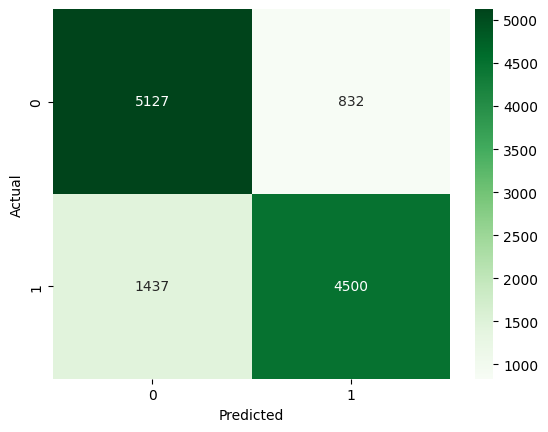

In [ ]:
show_performance(y_real, y_predic_classes)

#### Kaggle

In [ ]:
create_model_submission(df_hotels_test, model, ADAM_NAME, f1_score(y_real, y_predic_classes, average='binary'))

### **RMSprop**

In [ ]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics = [f1_m])

In [ ]:
historial_model_rmsprop = model.fit(x_train, y_train_encoder, epochs=300, batch_size=32)

Epoch 1/300
1487/1487 [==============================] - 5s 2ms/step - loss: 0.5865 - f1_m: 0.7267
Epoch 2/300
1487/1487 [==============================] - 4s 2ms/step - loss: 0.4815 - f1_m: 0.7536
Epoch 3/300
1487/1487 [==============================] - 8s 5ms/step - loss: 0.4752 - f1_m: 0.7587
Epoch 4/300
1487/1487 [==============================] - 7s 5ms/step - loss: 0.4733 - f1_m: 0.7599
Epoch 5/300
1487/1487 [==============================] - 9s 6ms/step - loss: 0.4695 - f1_m: 0.7635
Epoch 6/300
1487/1487 [==============================] - 9s 6ms/step - loss: 0.4679 - f1_m: 0.7634
Epoch 7/300
1487/1487 [==============================] - 8s 5ms/step - loss: 0.4659 - f1_m: 0.7644
Epoch 8/300
1487/1487 [==============================] - 8s 5ms/step - loss: 0.4611 - f1_m: 0.7682
Epoch 9/300
1487/1487 [==============================] - 3s 2ms/step - loss: 0.4596 - f1_m: 0.7670
Epoch 10/300
1487/1487 [==============================] - 3s 2ms/step - loss: 0.4563 - f1_m: 0.7700
Epoch 11/

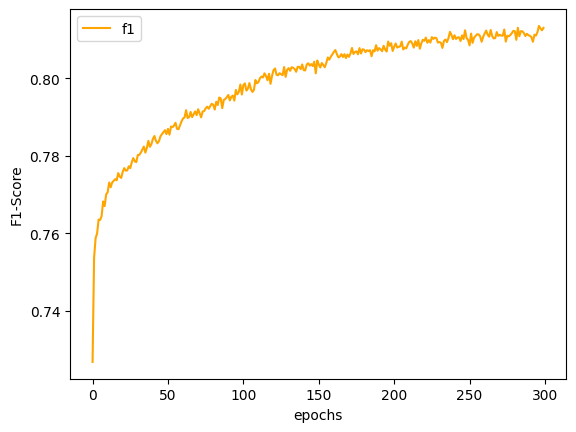

In [ ]:
epochs = range(300)

plt.plot(epochs, historial_model_rmsprop.history['f1_m'], color='orange', label='f1')
plt.xlabel("epochs")
plt.ylabel("F1-Score")
plt.legend()

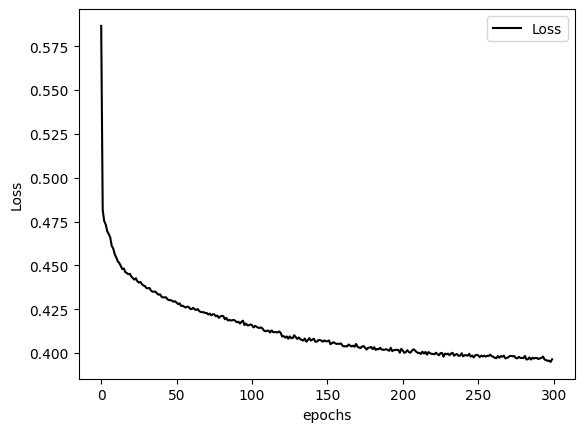

In [ ]:
epochs = range(300)

plt.plot(epochs, historial_model_rmsprop.history['loss'], color='black', label='Loss')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
y_predic = model.predict(x_test)

372/372 [==============================] - 1s 2ms/step


In [ ]:
y_predic_classes = np.argmax(y_predic,axis=1).tolist()
y_real = np.argmax(y_test_encoder,axis=1).tolist()

F1 Score: 0.80108372662122
Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.85      0.82      5959
           1       0.83      0.77      0.80      5937

    accuracy                           0.81     11896
   macro avg       0.81      0.81      0.81     11896
weighted avg       0.81      0.81      0.81     11896



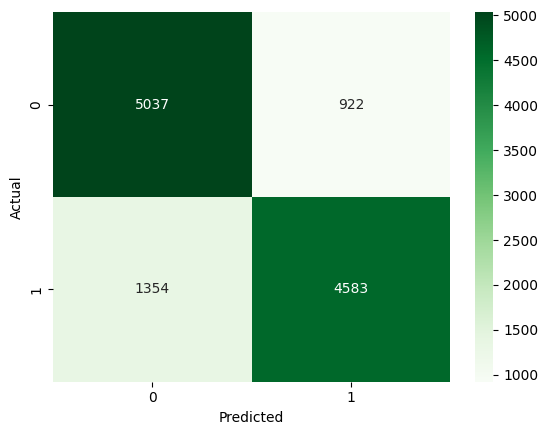

In [ ]:
show_performance(y_real, y_predic_classes)

#### Kaggle

In [ ]:
create_model_submission(df_hotels_test, model, RMSPROP_NAME, f1_score(y_real, y_predic_classes, average='binary'))

830/830 [==============================] - 1s 1ms/step


### Adadelta

In [ ]:
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.01, rho=0.9)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[f1_m])

In [ ]:
historial_model_adadelta = model.fit(x_train, y_train_encoder, epochs=150, batch_size=32)

Epoch 1/150
1487/1487 [==============================] - 12s 5ms/step - loss: 1.3158 - f1_m: 0.5201
Epoch 2/150
1487/1487 [==============================] - 8s 5ms/step - loss: 1.2086 - f1_m: 0.5575
Epoch 3/150
1487/1487 [==============================] - 7s 5ms/step - loss: 1.1214 - f1_m: 0.5953
Epoch 4/150
1487/1487 [==============================] - 7s 5ms/step - loss: 1.0469 - f1_m: 0.6216
Epoch 5/150
1487/1487 [==============================] - 6s 4ms/step - loss: 0.9824 - f1_m: 0.6365
Epoch 6/150
1487/1487 [==============================] - 9s 6ms/step - loss: 0.9251 - f1_m: 0.6530
Epoch 7/150
1487/1487 [==============================] - 6s 4ms/step - loss: 0.8746 - f1_m: 0.6638
Epoch 8/150
1487/1487 [==============================] - 8s 5ms/step - loss: 0.8298 - f1_m: 0.6757
Epoch 9/150
1487/1487 [==============================] - 8s 5ms/step - loss: 0.7965 - f1_m: 0.6798
Epoch 10/150
1487/1487 [==============================] - 4s 2ms/step - loss: 0.7649 - f1_m: 0.6881
Epoch 11

In [ ]:
y_predic = model.predict(x_test)

372/372 [==============================] - 1s 2ms/step


In [ ]:
y_predic_classes = np.argmax(y_predic,axis=1).tolist()
y_real = np.argmax(y_test_encoder,axis=1).tolist()

F1 Score: 0.7502048993716419
Classification Report: 
               precision    recall  f1-score   support

           0       0.73      0.84      0.79      5959
           1       0.82      0.69      0.75      5937

    accuracy                           0.77     11896
   macro avg       0.78      0.77      0.77     11896
weighted avg       0.78      0.77      0.77     11896



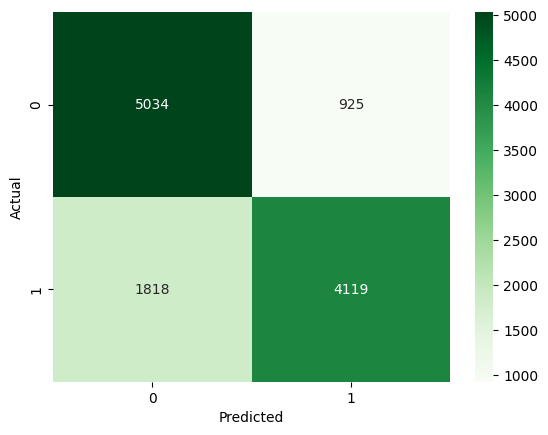

In [ ]:
show_performance(y_real, y_predic_classes)

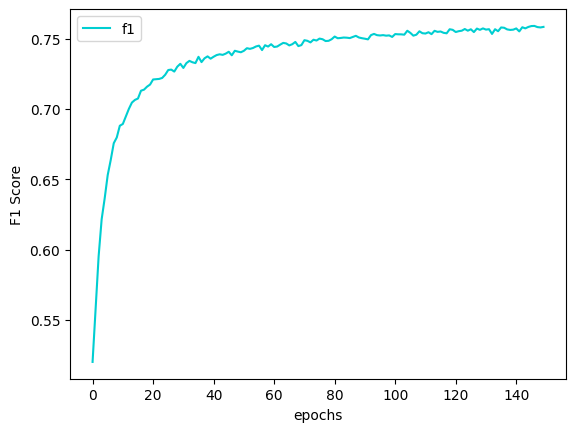

In [ ]:
epochs = range(150)

plt.plot(epochs, historial_model_adadelta.history['f1_m'], color='darkturquoise', label='f1')
plt.xlabel("epochs")
plt.ylabel("F1 Score")
plt.legend()

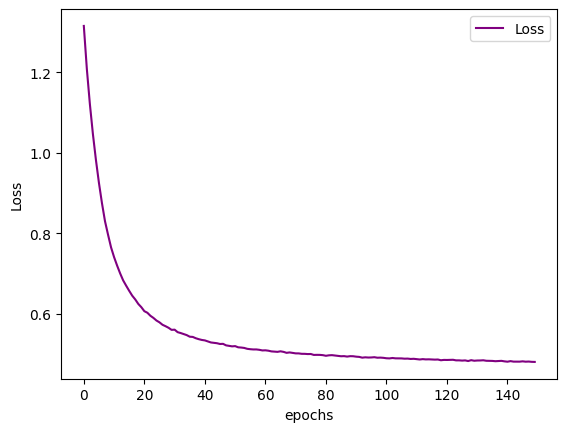

In [ ]:
epochs = range(150)

plt.plot(epochs, historial_model_adadelta.history['loss'], color='purple', label='Loss')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()

#### Kaggle

In [ ]:
create_model_submission(df_hotels_test, model, ADADELTA_NAME, f1_score(y_real, y_predic_classes, average='binary'))

# Red Neuronal - Optimizada

> Para optimizar nuestra red neuronal utilizamos `keras-tuner` para poder construir una arquitectura dinamica que nos permita evaluar las distintas combinaciones posibles ya sea de hiperparametros o arquitectura.

In [ ]:
def build_optimized_model(hp):
  
  hp_activation_input = hp.Choice('activation_input', values=['relu', 'sigmoid'])
  hp_activation_out = hp.Choice('activation_out', values=['softmax', 'sigmoid'])
  hp_loss = hp.Choice('loss', values=['binary_crossentropy'])
  hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  hp_dropout =  hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
  hp_dropout_2 =  hp.Float('dropout_rate_2', min_value=0.0, max_value=0.5, step=0.1)
  hp_regularizer = hp.Choice('regularizer', values=['l1', 'l2'])
  hp_initializers = hp.Choice('initializer', values=['zeros', 'random_normal', 'uniform', 'glorot_uniform'])


  hp_nodes = hp.Int('neurons', min_value=32, max_value=512, step= 32)

  model = keras.Sequential()
  model.add(keras.layers.Dense(units=hp_nodes, 
                               input_shape=(d_in,), 
                               activation=hp_activation_input,
                               kernel_initializer=hp_initializers))
  model.add(keras.layers.Dropout(hp_dropout))
  model.add(keras.layers.Dense(units=32, activation=hp_activation_input))
  model.add(keras.layers.Dropout(hp_dropout_2))
  model.add(keras.layers.Dense(cant_clases, activation=hp_activation_out))

  hp_optimizer = hp.Choice("optimizer", values=['Adam', 'RMSprop'])
  if hp_optimizer == 'Adam':
    optimizer = keras.optimizers.Adam(learning_rate=hp_lr)
  elif hp_optimizer == 'RMSprop':
    optimizer = keras.optimizers.RMSprop(learning_rate=hp_lr)

  model.compile(optimizer=optimizer, loss=hp_loss, metrics=[f1_m])
  return model


> Empezamos inicializando el tuner de keras, en este caso usamos `randomSearch` con 25 trials o combinaciones a probar, enfocandonos en maximizar el F1 Score y aplicando un early stopping cuando se deteriore la metrica de perdida en validacion.

In [ ]:
tuner = kt.RandomSearch(build_optimized_model,objective=kt.Objective('val_f1_m', 'max'), max_trials=25,directory='keras_tuner',project_name='hotel_bookings',overwrite=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(x_train, y_train_encoder, epochs=30, validation_split=0.2, callbacks=[stop_early])

Trial 25 Complete [00h 03m 04s]
val_f1_m: 0.7739724516868591

Best val_f1_m So Far: 0.8084666728973389
Total elapsed time: 00h 43m 50s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_hps.values

{'activation_input': 'sigmoid',
 'activation_layer': 'sigmoid',
 'activation_out': 'softmax',
 'loss': 'binary_crossentropy',
 'learning_rate': 0.01,
 'dropout_rate': 0.30000000000000004,
 'dropout_rate_2': 0.4,
 'regularizer': 'l2',
 'initializer': 'uniform',
 'neurons': 192,
 'optimizer': 'Adam'}

> 

> Una vez conseguidos los mejores hiperparametros, procedemos a entrenar con una cantidad de epochs mayor, conservando el early stopping con una tolerancia un poco mayor y usando como data de validacion el split (80/20) que realizamos anteriormente.

In [ ]:
model = tuner.hypermodel.build(best_hps)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
history = model.fit(x_train, y_train_encoder, epochs=200, validation_data = (x_test, y_test_encoder) ,callbacks=[stop_early], batch_size=64)

Epoch 1/200
744/744 [==============================] - 5s 5ms/step - loss: 0.4884 - f1_m: 0.7513 - val_loss: 0.4551 - val_f1_m: 0.7737
Epoch 2/200
744/744 [==============================] - 2s 3ms/step - loss: 0.4585 - f1_m: 0.7706 - val_loss: 0.4506 - val_f1_m: 0.7737
Epoch 3/200
744/744 [==============================] - 2s 3ms/step - loss: 0.4499 - f1_m: 0.7724 - val_loss: 0.4467 - val_f1_m: 0.7721
Epoch 4/200
744/744 [==============================] - 2s 3ms/step - loss: 0.4425 - f1_m: 0.7760 - val_loss: 0.4445 - val_f1_m: 0.7753
Epoch 5/200
744/744 [==============================] - 2s 3ms/step - loss: 0.4395 - f1_m: 0.7790 - val_loss: 0.4308 - val_f1_m: 0.7816
Epoch 6/200
744/744 [==============================] - 4s 5ms/step - loss: 0.4356 - f1_m: 0.7796 - val_loss: 0.4331 - val_f1_m: 0.7825
Epoch 7/200
744/744 [==============================] - 3s 4ms/step - loss: 0.4322 - f1_m: 0.7809 - val_loss: 0.4282 - val_f1_m: 0.7843
Epoch 8/200
744/744 [==============================] - 

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 192)               8064      
                                                                 
 dropout_4 (Dropout)         (None, 192)               0         
                                                                 
 dense_7 (Dense)             (None, 32)                6176      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 2)                 66        
                                                                 
Total params: 14,306
Trainable params: 14,306
Non-trainable params: 0
_________________________________________________________________


## Graficos - Red Optimizada

In [ ]:
plt.figure(figsize = (12, 6))

train_loss = history.history['loss']
val_loss = history.history['val_loss'] 
epoch = range(0, 121)

loss = pd.DataFrame({'train_loss' : train_loss, 'val_loss' : val_loss})

px.line(data_frame = loss, x = epoch, y = ['val_loss', 'train_loss'], title = 'Funcion de perdida en Train y Validacion',
        template = 'plotly_dark')

<Figure size 1200x600 with 0 Axes>

In [ ]:
plt.figure(figsize = (12, 6))

train_f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m'] 
epoch = range(0, 121)


f1 = pd.DataFrame({'train_f1' : train_f1, 'val_f1_m' : val_f1})

px.line(data_frame = f1, x = epoch, y = ['val_f1_m', 'train_f1'], title = 'F1 Score en Train y Validacion',
        template = 'plotly_dark')

<Figure size 1200x600 with 0 Axes>

## Matriz de Confusion - Red Optimizada

In [ ]:
y_predic = model.predict(x_test)

372/372 [==============================] - 1s 1ms/step


In [ ]:
y_predic_classes = np.argmax(y_predic,axis=1).tolist()
y_real = np.argmax(y_test_encoder,axis=1).tolist()

F1 Score: 0.8008944543828265
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.87      0.82      5959
           1       0.85      0.75      0.80      5937

    accuracy                           0.81     11896
   macro avg       0.82      0.81      0.81     11896
weighted avg       0.82      0.81      0.81     11896



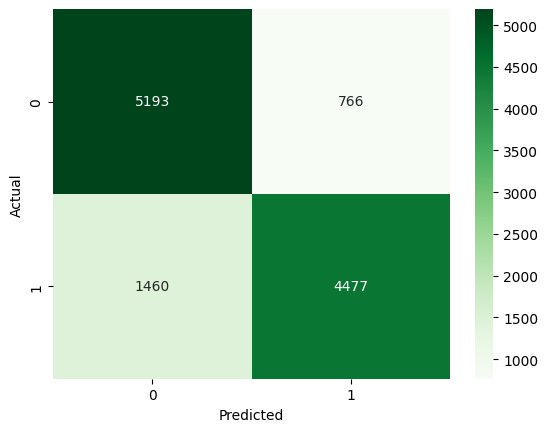

In [ ]:
show_performance(y_real, y_predic_classes)

In [ ]:
create_model_submission(df_hotels_test, model, NN_OPT_NAME, f1_score(y_real, y_predic_classes, average='binary'))

830/830 [==============================] - 1s 1ms/step
